<a href="https://colab.research.google.com/github/aruaru0/bert-classification-test/blob/main/HuggingFace_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# transformerのインストールなど

In [1]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install git+https://github.com/huggingface/accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.8 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-9y74dx6f
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-9y74dx6f
  Resolved https://github.com/huggingface/accelerate to commit 4a1d5b1

In [2]:
!pip install fugashi
!pip install ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 31.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556703 sha256=a122ba82de40380b93510aa3564546cb7124a83fe02feeef04cc3b0b3993629d
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


# データセットを準備

In [3]:
from datasets import load_dataset

dataset = load_dataset("amazon_reviews_multi", "ja")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Tokenizerの取得

In [4]:
from transformers import AutoTokenizer

model_ckpt = "cl-tohoku/bert-base-japanese"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# データサイズを減らす

In [5]:
SEED = 42
TRAIN_SIZE = 10000
TEST_SIZE = 1000

dataset["train"] = dataset["train"].shuffle(seed=SEED).select(range(TRAIN_SIZE))
dataset["validation"] = dataset["validation"].shuffle(seed=SEED).select(range(TEST_SIZE))
dataset["test"] = dataset["test"].shuffle(seed=SEED).select(range(TEST_SIZE))

# データセットの加工

In [6]:
import torch

def tokenize(batch):
    enc =  tokenizer(batch["review_body"], padding=True, truncation=True)
    targets = batch['stars']-1
    enc.update({'labels': targets})
    return enc

In [7]:
dataset_encoded = dataset.map(tokenize)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
small_train_dataset = dataset_encoded['train']
small_valid_dataset = dataset_encoded['validation']
small_test_dataset = dataset_encoded['test']

# 学習

In [9]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 5

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    preds, labels = pred
    preds = preds.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [11]:
from transformers import TrainingArguments

batch_size = 16
logging_steps = len(small_train_dataset) // batch_size
model_name = "amazon-review-classification-bert"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error"
)

In [12]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=small_train_dataset,
    eval_dataset=small_valid_dataset,
    tokenizer=tokenizer
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.197500,1.113923,0.506000,0.493804
2,0.939400,1.085442,0.531000,0.529252


TrainOutput(global_step=1250, training_loss=1.068459228515625, metrics={'train_runtime': 789.5051, 'train_samples_per_second': 25.332, 'train_steps_per_second': 1.583, 'total_flos': 2160709741030464.0, 'train_loss': 1.068459228515625, 'epoch': 2.0})

# テストデータに対する結果を評価


In [13]:
preds_output = trainer.predict(small_test_dataset)

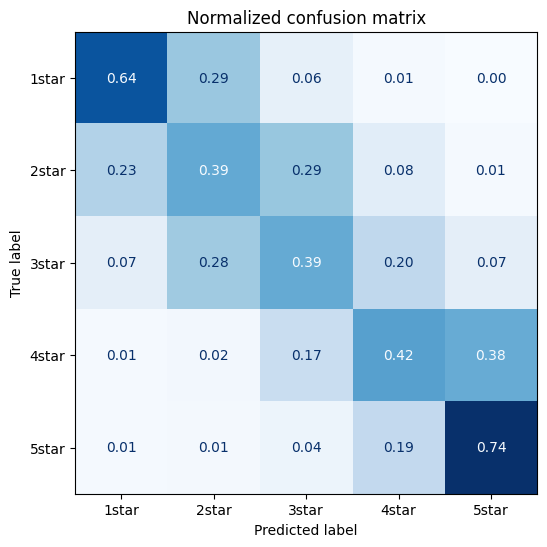

In [14]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(small_test_dataset["labels"])
labels = ["1star", "2star", "3star", "4star", "5star"]
#dataset_encoded["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

# モデルの保存、読み込み

In [15]:
trainer.save_model(f"./{model_name}-test")

In [16]:
tokenizer = AutoTokenizer\
    .from_pretrained(f"./{model_name}-test")

model = (AutoModelForSequenceClassification
    .from_pretrained(f"./{model_name}-test")
    .to(device))